Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_9 (Lambda)           (None, 66, 200, 3)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_36 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_37 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_38 (Conv2D)          (None, 1, 7, 64)          27712     
                                                                 
 dropout_10 (Dropout)        (None, 1, 7, 64)          0         
                                                                 
 flatten_5 (Flatten)         (None, 448)              

C:\Users\tranc\AppData\Local\Temp\ipykernel_6348\508410430.py:81: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(batch_generator(data_dir, X_train, y_train, batch_size, True),


IndexError: boolean index did not match indexed array along dimension 0; dimension is 160 but corresponding boolean dimension is 66

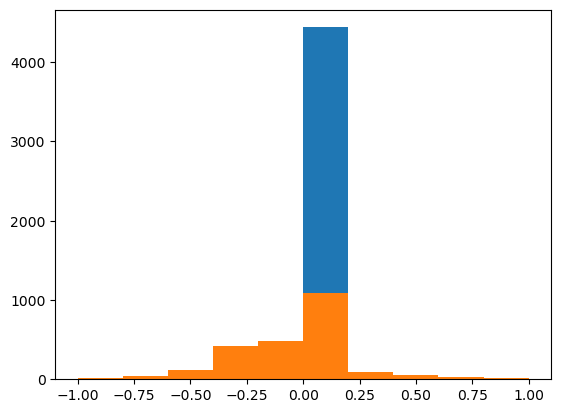

In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, Dropout, Dense, Flatten
from keras.regularizers import l2

from utils import INPUT_SHAPE, batch_generator

# Thư mục để dữ liệu
data_dir = 'C:/Users/tranc/Downloads/simulator-windows-64'
# Đọc file driving_log.csv với các cột tương ứng
data_df = pd.read_csv(os.path.join(os.getcwd(), data_dir, 'driving_log.csv'), \
        names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

# Lấy đường dẫn đến ảnh ở camera giữa, trái, phải
X = data_df[['center', 'left', 'right']].values
# Lấy góc lái của ô tô
y = data_df['steering'].values

# Vẽ histogram dữ liệu
plt.hist(y)

# Loại bỏ và chỉ lấy 1000 dữ liệu có góc lái ở 0
pos_zero = np.array(np.where(y==0)).reshape(-1, 1)
pos_none_zero = np.array(np.where(y!=0)).reshape(-1, 1)
np.random.shuffle(pos_zero)
pos_zero = pos_zero[:1000]

pos_combined = np.vstack((pos_zero, pos_none_zero))
pos_combined = list(pos_combined)

y = y[pos_combined].reshape(len(pos_combined))
X = X[pos_combined, :].reshape((len(pos_combined), 3))

# After process
plt.hist(y)

# Chia ra traing set và validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, \
                random_state=0)
# X¥y dựng model
model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
model.add(Conv2D(24,(5,5), strides=(2, 2), activation='elu'))
model.add(Conv2D(36,(5,5), strides=(2, 2), activation='elu'))
model.add(Conv2D(48,(5,5), strides=(2, 2), activation='elu'))
model.add(Conv2D(64, 3, 3, activation='elu'))
# model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

nb_epoch = 10
samples_per_epoch = 1000
batch_size = 32
save_best_only = True
learning_rate = 1e-4

# Checkpoint này để nói cho model lưu lại model nếu validation loss thấp nhất
checkpoint = ModelCheckpoint('models/model-{epoch:03d}.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=save_best_only,
                                mode='auto')
# Dùng mean_squrared_error làm loss function
model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))

# Train model
H = model.fit_generator(batch_generator(data_dir, X_train, y_train, batch_size, True),
                    steps_per_epoch = samples_per_epoch,
                    epochs = nb_epoch,
                    verbose=1,
                    callbacks=[checkpoint],
                    validation_data=batch_generator(data_dir, X_valid, y_valid, batch_size, False),
                    validation_steps=len(X_valid),
                    max_queue_size=1,
                    )